In [1]:
import sys
import cv
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tippy.segmentations as se
import tippy.basic_operations as bo
import tippy.display_operations as do
from skfuzzy import control as ctrl
from sklearn.metrics import confusion_matrix
from PIL import Image
from skimage import morphology as morph
from scipy import misc
from scipy import ndimage
from time import time
from itertools import compress

In [2]:
# Sørensen–Dice

def dice(ref1, img):
    ref1 = np.asarray(ref1).astype(np.bool)
    img = np.asarray(img).astype(np.bool)
    
    if ref1.shape != img.shape:
        raise ValueError("Shape mismatch: ref and img must have the same shape")
    
    TP = np.logical_and(ref1,img) # TRUE POSITIVE (interseção das imagens)
    
    return (2.0*TP.sum()) / (ref1.sum() + img.sum())

In [3]:
# Jaccard

def jaccard(ref1, img):
    ref1 = np.asarray(ref1).astype(np.bool)
    img = np.asarray(img).astype(np.bool)
    
    if ref1.shape != img.shape:
        raise ValueError("Shape mismatch: ref and img must have the same shape")
        
    TP = np.logical_and(ref1,img) # TRUE POSITIVE (interseção das imagens)
    return (TP.sum())*1.0 / (ref1.sum() + img.sum() - TP.sum())

In [4]:
# confusion_matrix

def conf_matrix(ref1, img):
    ref1 = np.asarray(ref1).astype(np.bool)
    img = np.asarray(img).astype(np.bool)
    
    cm = confusion_matrix(ref1, img)    
    total = sum(sum(cm))
    
    TP = cm[1,1]
    TN = cm[0,0]
    FN = cm[1,0]
    FP = cm[0,1]
       
    accuracy = (TP*1.0 + TN) / total
    sensitivity = TP*1.0 / (TP+FN)
    specificity = TN*1.0 / (TN+FP)
    return(accuracy, sensitivity, specificity)

In [5]:
def calc_estatistica(ref1, img):
    dice1 = dice(ref1, img)
    jacc1 = jaccard(ref1, img)
    conf1 = conf_matrix(ref1.flatten(), img.flatten())
    return([dice1, jacc1, conf1[0], conf1[1], conf1[2]])

In [6]:
def junta_imgs(ref1, img1, img2):
    start = time()
    
    ref1 = np.asarray(ref1).astype(np.bool)
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)
    
    img_final = np.logical_or(img1, img2)
    
    lista = calc_estatistica(ref1, img_final)
    
    tempo_final = time() - start
    
    return(img_final, lista[0], lista[1], lista[2], lista[3], lista[4], tempo_final)

In [7]:
def fuzzySystem_OP(pixel, vm):

    # pixelIN variables
    x_pixelIN = np.linspace(0, 1, 100)
    x_pixelOUT  = np.linspace(0, 1, 100)

    # Generate fuzzy membership functions
    pixelIN_sm = fuzz.trapmf(x_pixelIN, [0, 0, 0.15*vm, 0.6*vm])
    pixelIN_md = fuzz.trimf(x_pixelIN, [0.5*vm, vm, 1.4*vm])
    pixelIN_la = fuzz.trapmf(x_pixelIN, [1.3*vm, 1.6*vm, 1, 1])
    
    pixelOUT_sm = fuzz.trapmf(x_pixelOUT, [0, 0, 0.05, 0.1])
    pixelOUT_md = fuzz.trimf(x_pixelOUT, [0.45, 0.5, 0.55])
    pixelOUT_la = fuzz.trapmf(x_pixelOUT, [0.9, 0.95, 1, 1])
    
    # Activation of fuzzy membership functions at vm using fuzz.interp_membership 
    pixelIN_level_sm = fuzz.interp_membership(x_pixelIN, pixelIN_sm, pixel)
    pixelIN_level_md = fuzz.interp_membership(x_pixelIN, pixelIN_md, pixel)
    pixelIN_level_la = fuzz.interp_membership(x_pixelIN, pixelIN_la, pixel)

    # Rules for OP
    rule1 = np.fmin(pixelIN_level_sm, pixelOUT_sm) # edge
    rule2 = np.fmin(pixelIN_level_md, pixelOUT_la) # liver
    rule3 = np.fmin(pixelIN_level_la, pixelOUT_md) # vessel
    
    # Aggregating the output membership functions
    aggregated = np.fmax(rule1, np.fmax(rule2, rule3))
    
    # Calculating the result
    output = fuzz.defuzz(x_pixelOUT, aggregated, 'centroid')
    output_activation = fuzz.interp_membership(x_pixelOUT, aggregated, output) # for plot
    
    return(output)

def fuzzySystem_IP(pixel, vm):

    # pixelIN variables
    x_pixelIN = np.linspace(0, 1, 100)
    x_pixelOUT  = np.linspace(0, 1, 100)

    # Generate fuzzy membership functions
    pixelIN_sm = fuzz.trapmf(x_pixelIN, [0, 0, 0.15*vm, 0.9*vm])
    pixelIN_md = fuzz.trimf(x_pixelIN, [0.87*vm, vm, 1.3*vm])
    pixelIN_la = fuzz.trapmf(x_pixelIN, [1.2*vm, 1.6*vm, 1, 1])

    pixelOUT_sm = fuzz.trapmf(x_pixelOUT, [0, 0, 0.05, 0.1])
    pixelOUT_md = fuzz.trimf(x_pixelOUT, [0.45, 0.5, 0.55])
    pixelOUT_la = fuzz.trapmf(x_pixelOUT, [0.9, 0.95, 1, 1])

    # Activation of fuzzy membership functions at vm using fuzz.interp_membership 
    pixelIN_level_sm = fuzz.interp_membership(x_pixelIN, pixelIN_sm, pixel)
    pixelIN_level_md = fuzz.interp_membership(x_pixelIN, pixelIN_md, pixel)
    pixelIN_level_la = fuzz.interp_membership(x_pixelIN, pixelIN_la, pixel)
    
    # Rules for IP
    rule1 = np.fmin(pixelIN_level_sm, pixelOUT_md) # vessel
    rule2 = np.fmin(pixelIN_level_md, pixelOUT_la) # liver
    rule3 = np.fmin(pixelIN_level_la, pixelOUT_sm) # edge
    
    # Aggregating the output membership functions
    aggregated = np.fmax(rule1, np.fmax(rule2, rule3))
    
    # Calculating the result
    output = fuzz.defuzz(x_pixelOUT, aggregated, 'centroid')
    output_activation = fuzz.interp_membership(x_pixelOUT, aggregated, output) # for plot
    
    return(output)

In [8]:
def fuzzy_seg(imgOP_orig, imgIP_orig, ref, vmed_op, vmed_ip, seed, indices_list):

    ###############################################################################
    '''
    pixelOP = np.genfromtxt("dataset01\s01-27-op-231-94-102.txt")
    pixelIP = np.genfromtxt("dataset01\s01-27-ip-432.txt")
    ref = np.genfromtxt("dataset01\s01-25-ref.txt")

    vmed_op = 231.0
    vmed_ip = 432.0
    seed = (94,102)
    '''
    ###############################################################################

    vmed_op = vmed_op/4095.0
    vmed_ip = vmed_ip/4095.0
    
    imgOP = np.zeros(imgOP_orig.shape)
    imgIP = np.zeros(imgIP_orig.shape)

    pixelOP = imgOP_orig*(1.0/4095.0)
    pixelIP = imgIP_orig*(1.0/4095.0)
    
    for i in (indices_list):
        imgOP[i] = fuzzySystem_OP(pixelOP[i], vmed_op)

    for i in (indices_list):
        imgIP[i] = fuzzySystem_IP(pixelIP[i], vmed_ip)
    
    plt.imshow(imgOP)
    plt.show()
    
    plt.imshow(imgIP)
    plt.show()
    
    ###############################################################################
    
    maskOP = imgOP > 0.6
    maskIP = imgIP > 0.6
       
    maskAND = np.logical_and(maskOP, maskIP)
    maskerosion = morph.binary_erosion(maskAND)
    maskopen = morph.binary_opening(maskerosion)
    
    plt.imshow(maskopen)
    plt.show()
    
    misc.imsave('maskfinal.bmp', maskopen)

    ###############################################################################

    user_input = 0

    img_name = "maskfinal.bmp"
    threshold = 20
    img = cv.LoadImage(img_name, cv.CV_LOAD_IMAGE_GRAYSCALE)
    out_img = se.simple_region_growing(img, seed, threshold)
    out_img = np.asarray(out_img[:,:])
   
    return out_img

In [9]:
def simple_region_growing(img, seed, threshold=1):
    """
    A (very) simple implementation of region growing.
    Extracts a region of the input image depending on a start position and a stop condition.
    The input should be a single channel 8 bits image and the seed a pixel position (x, y).
    The threshold corresponds to the difference between outside pixel intensity and mean intensity of region.
    In case no new pixel is found, the growing stops.
    Outputs a single channel 8 bits binary (0 or 255) image. Extracted region is highlighted in white.
    """

    try:
        dims = cv.GetSize(img)
    except TypeError:
        raise TypeError("(%s) img : IplImage expected!" % (sys._getframe().f_code.co_name))

    # img test
    if not(img.depth == cv.IPL_DEPTH_8U):
        raise TypeError("(%s) 8U image expected!" % (sys._getframe().f_code.co_name))
    elif not(img.nChannels is 1):
        raise TypeError("(%s) 1C image expected!" % (sys._getframe().f_code.co_name))
    # threshold tests
    if (not isinstance(threshold, int)) :
        raise TypeError("(%s) Int expected!" % (sys._getframe().f_code.co_name))
    elif threshold < 0:
        raise ValueError("(%s) Positive value expected!" % (sys._getframe().f_code.co_name))
    # seed tests
    if not((isinstance(seed, tuple)) and (len(seed) is 2) ) :
        raise TypeError("(%s) (x, y) variable expected!" % (sys._getframe().f_code.co_name))

    if (seed[0] or seed[1] ) < 0 :
        raise ValueError("(%s) Seed should have positive values!" % (sys._getframe().f_code.co_name))
    elif ((seed[0] > dims[0]) or (seed[1] > dims[1])):
        raise ValueError("(%s) Seed values greater than img size!" % (sys._getframe().f_code.co_name))

    reg = cv.CreateImage( dims, cv.IPL_DEPTH_8U, 1)
    cv.Zero(reg)

    #parameters
    mean_reg = float(img[seed[1], seed[0]])
    size = 1
    pix_area = dims[0]*dims[1]

    contour = [] # will be [ [[x1, y1], val1],..., [[xn, yn], valn] ]
    contour_val = []
    dist = 0
    # TODO: may be enhanced later with 8th connectivity
    orient = [(1, 0), (0, 1), (-1, 0), (0, -1)] # 4 connectivity
    cur_pix = [seed[0], seed[1]]

    #Spreading
    while(dist<threshold and size<pix_area):
    #adding pixels
        for j in range(4):
            #select new candidate
            temp_pix = [cur_pix[0] +orient[j][0], cur_pix[1] +orient[j][1]]

            #check if it belongs to the image
            is_in_img = dims[0]>temp_pix[0]>0 and dims[1]>temp_pix[1]>0 #returns boolean
            #candidate is taken if not already selected before
            if (is_in_img and (reg[temp_pix[1], temp_pix[0]]==0)):
                contour.append(temp_pix)
                contour_val.append(img[temp_pix[1], temp_pix[0]] )
                reg[temp_pix[1], temp_pix[0]] = 150
        #add the nearest pixel of the contour in it
        dist = abs(int(np.mean(contour_val)) - mean_reg)

        dist_list = [abs(i - mean_reg) for i in contour_val ]
        dist = min(dist_list)    #get min distance
        index = dist_list.index(min(dist_list)) #mean distance index
        size += 1 # updating region size
        reg[cur_pix[1], cur_pix[0]] = 255

        #updating mean MUST BE FLOAT
        mean_reg = (mean_reg*size + float(contour_val[index]))/(size+1)
        #updating seed
        cur_pix = contour[index]

        #removing pixel from neigborhood
        del contour[index]
        del contour_val[index]

    return reg

In [10]:
def true_Indices(imgCV, seed, threshold=15):
    pre_grow_cv = se.simple_region_growing(imgCV, seed, threshold)
    pre_grow = np.asarray(pre_grow_cv[:,:]).astype(np.bool)
    #plt.imshow(pre_grow, cmap='gray')
    #plt.show()
           
    pre_grow_dim = pre_grow.shape
    pre_grow_flat = pre_grow.flatten()
    
    true_indices_flat = list(compress(xrange(len(pre_grow_flat)), pre_grow_flat))
    true_indices = np.unravel_index(true_indices_flat,pre_grow_dim)
    return zip(true_indices[0],true_indices[1])

In [11]:
def start_segm(op, ip, ref):
    start = time()
    
    user_input = 0
        
    #get seeds from user
    misc.imsave('inputOP.bmp', op) #saves OP image as bitmap to be used by CV
    img_name = "inputOP.bmp"
    img = cv.LoadImage(img_name, cv.CV_LOAD_IMAGE_GRAYSCALE)
    inputseeds = bo.mouse_point(img, mode="M") # waits for user click to get seed, returns tuple inside a list
    print inputseeds    
    
    #get max, min and mean grey values from seeds
    grey_valueOP = []
    grey_valueIP = []
    for tuples in inputseeds:
        grey_valueOP = np.append(grey_valueOP, op[tuples[1],tuples[0]])
        grey_valueIP = np.append(grey_valueIP, ip[tuples[1],tuples[0]])
    
    ################################################################################################################
    
    #para fuzzy com vm = max
    grey_max_OP = np.max(grey_valueOP)
    grey_max_IP = np.max(grey_valueIP)
    seed_max = inputseeds[np.argmax(grey_valueOP)] #get the seed  (y,x) corresponding to the max grey value
    print seed_max
    true_idx_max = true_Indices(img, seed_max)
    result_max = fuzzy_seg(inputOP, inputIP, inputref, grey_max_OP, grey_max_IP, seed_max, true_idx_max)
     
    #para fuzzy com vm = min
    grey_min_OP = np.min(grey_valueOP)
    grey_min_IP = np.min(grey_valueIP)
    seed_min = inputseeds[np.argmin(grey_valueOP)] #get the seed  (y,x) corresponding to the minimum grey value
    print seed_min
    true_idx_min = true_Indices(img, seed_min)
    result_min = fuzzy_seg(inputOP, inputIP, inputref, grey_min_OP, grey_min_IP, seed_min, true_idx_min)
    
        
    #para fuzzy com vm = mean
    grey_mean_OP = np.mean(grey_valueOP)
    grey_mean_IP = np.mean(grey_valueIP)
    seed_mean = inputseeds[min(range(len(grey_valueOP)), key=lambda i: abs(grey_valueOP[i]-grey_mean_OP))] #get the seed  (y,x)
    print seed_mean
    true_idx_mean = true_Indices(img, seed_mean)
    result_mean = fuzzy_seg(inputOP, inputIP, inputref, grey_mean_OP, grey_mean_IP, seed_mean, true_idx_mean)
    
    ################################################################################################################
   
    combined_result = np.logical_or(np.logical_or(result_min,result_mean),result_max)
   
    ################################################################################################################
    
    # plot
    f, axarr = plt.subplots(2,2,figsize=(10,10))
    
    axarr[0,0].imshow(op, cmap='gray')
    axarr[0,0].set_title('OP')
    
    axarr[0,1].imshow(ip, cmap='gray')
    axarr[0,1].set_title('IP')
    
    axarr[1,0].imshow(ref, cmap='gray')
    axarr[1,0].set_title('Reference')
    
    axarr[1,1].imshow(combined_result, cmap='gray')
    axarr[1,1].set_title('Result')
    
    plt.show()
    
    ''' 
    plt.imshow(ref, cmap='gray')
    plt.title('ref')
    plt.show()

    plt.imshow(maskOP, cmap='gray')
    plt.title('maskOP')
    plt.show()

    plt.imshow(maskIP, cmap='gray')
    plt.title('maskIP')
    plt.show()

    plt.imshow(maskAND, cmap='gray')
    plt.title('maskAND')
    plt.show()

    plt.imshow(maskopen, cmap='gray')
    plt.title('maskopen')
    plt.show()

    plt.imshow(out_img, cmap='gray')
    plt.title('result')
    plt.show()'''
    
    lista = calc_estatistica(ref, combined_result)
    tempo_final = time() - start
    
    del(inputseeds)
    del(seed_max)
    del(seed_min)
    del(seed_mean)
    
    return(combined_result, lista[0], lista[1], lista[2], lista[3], lista[4], tempo_final)

## S02

In [12]:
listaDICE_S01_35 = []
listaJACC_S01_35 = []
listaACCU_S01_35 = []
listaSENS_S01_35 = []
listaSPEC_S01_35 = []
listaTEMPO_S01_35 = []

[(50, 126), (54, 147)]
(50, 126)


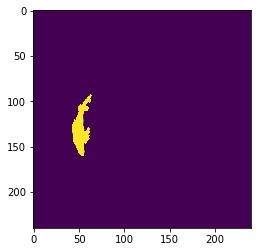

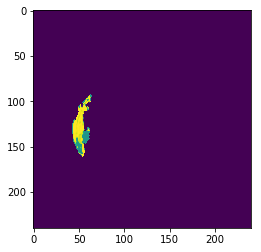

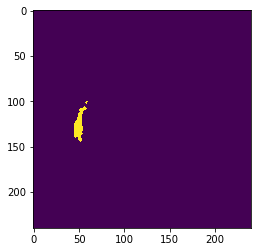

(54, 147)


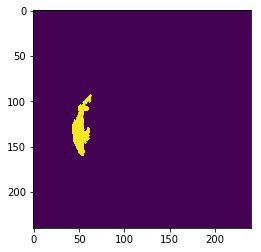

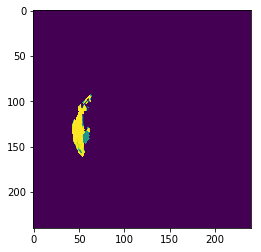

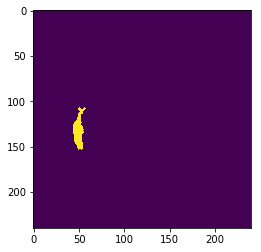

(50, 126)


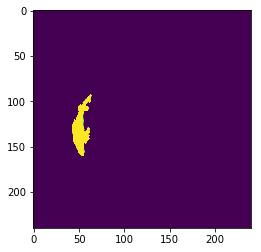

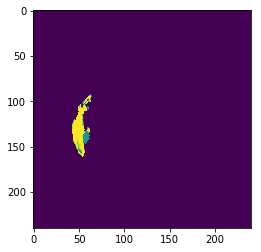

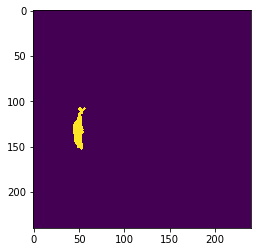

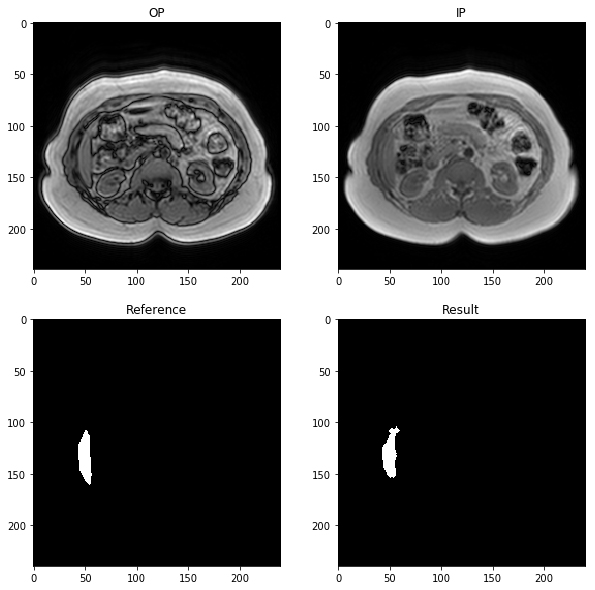

10
10
10
10
10
10


In [25]:
# S01-35

inputOP = np.genfromtxt("dataset02\s03-35-op-436-72-196.txt")
inputIP = np.genfromtxt("dataset02\s03-35-ip-430.txt")
inputref = np.genfromtxt("dataset02\s03-35-ref.txt")

result_s01_35, dice_f35, jacc_f35, accu_f35, sens_f35, spec_f35, tempo_f35 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s02_35_10.bmp', result_s01_35)

listaDICE_S01_35.append(dice_f35)
listaJACC_S01_35.append(jacc_f35)
listaACCU_S01_35.append(accu_f35)
listaSENS_S01_35.append(sens_f35)
listaSPEC_S01_35.append(spec_f35)
listaTEMPO_S01_35.append(tempo_f35)

print(len(listaDICE_S01_35))
print(len(listaJACC_S01_35))
print(len(listaACCU_S01_35))
print(len(listaSENS_S01_35))
print(len(listaSPEC_S01_35))
print(len(listaTEMPO_S01_35))

del(inputOP)
del(inputIP)
del(inputref)

In [83]:
print np.mean(listaDICE_S01_35)
print np.mean(listaJACC_S01_35)
print np.mean(listaACCU_S01_35)
print np.mean(listaSENS_S01_35)
print np.mean(listaSPEC_S01_35)
print np.mean(listaTEMPO_S01_35)

0.884889554602
0.79416998727
0.998020833333
0.913541666667
0.998730742297
9.67159996033


In [26]:
listaDICE_S01_37 = []
listaJACC_S01_37 = []
listaACCU_S01_37 = []
listaSENS_S01_37 = []
listaSPEC_S01_37 = []
listaTEMPO_S01_37 = []

[(52, 123), (52, 152)]
(52, 123)


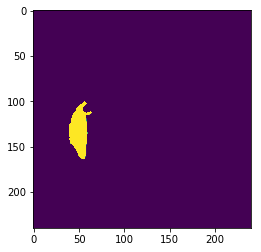

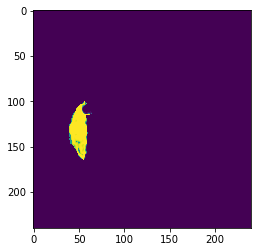

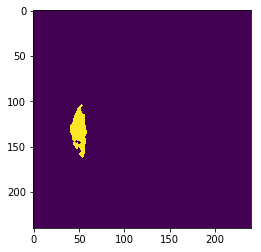

(52, 152)


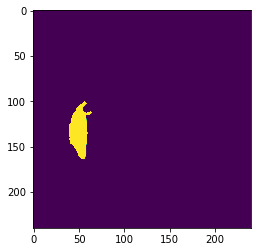

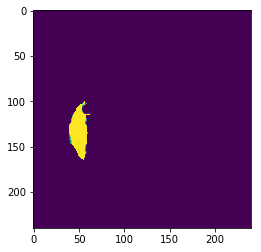

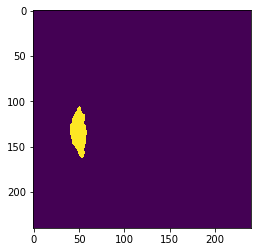

(52, 123)


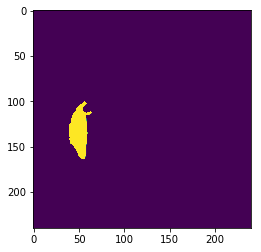

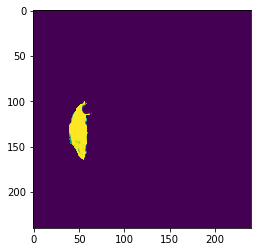

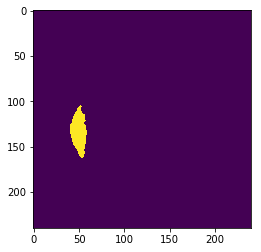

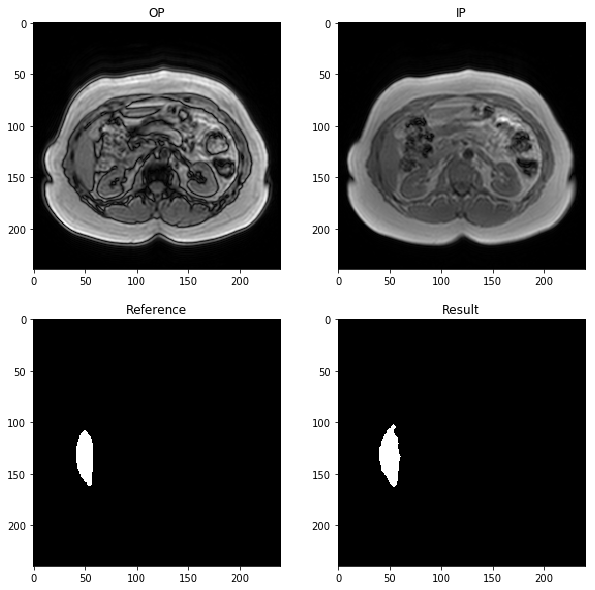

10
10
10
10
10
10


In [36]:
# S01-51

inputOP = np.genfromtxt("dataset02\s03-37-op-432-74-196.txt")
inputIP = np.genfromtxt("dataset02\s03-37-ip-425.txt")
inputref = np.genfromtxt("dataset02\s03-37-ref.txt")

result_s01_37, dice_f37, jacc_f37, accu_f37, sens_f37, spec_f37, tempo_f37 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s02_37_10.bmp', result_s01_37)

listaDICE_S01_37.append(dice_f37)
listaJACC_S01_37.append(jacc_f37)
listaACCU_S01_37.append(accu_f37)
listaSENS_S01_37.append(sens_f37)
listaSPEC_S01_37.append(spec_f37)
listaTEMPO_S01_37.append(tempo_f37)

print(len(listaDICE_S01_37))
print(len(listaJACC_S01_37))
print(len(listaACCU_S01_37))
print(len(listaSENS_S01_37))
print(len(listaSPEC_S01_37))
print(len(listaTEMPO_S01_37))

del(inputOP)
del(inputIP)
del(inputref)

In [84]:
print np.mean(listaDICE_S01_37)
print np.mean(listaJACC_S01_37)
print np.mean(listaACCU_S01_37)
print np.mean(listaSENS_S01_37)
print np.mean(listaSPEC_S01_37)
print np.mean(listaTEMPO_S01_37)

0.898994737459
0.81652841831
0.997383680556
0.997916666667
0.997377388983
10.9504000187


In [38]:
listaDICE_S01_39 = []
listaJACC_S01_39 = []
listaACCU_S01_39 = []
listaSENS_S01_39 = []
listaSPEC_S01_39 = []
listaTEMPO_S01_39 = []

[(55, 121), (58, 137), (53, 154)]
(55, 121)


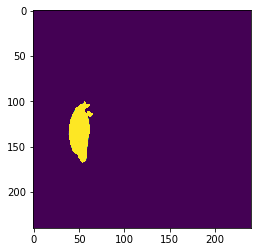

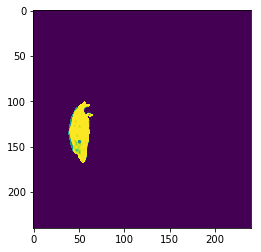

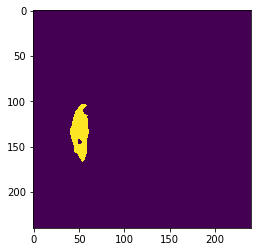

(53, 154)


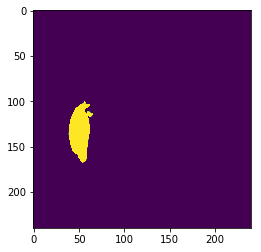

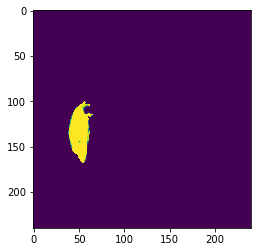

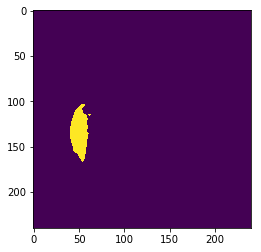

(58, 137)


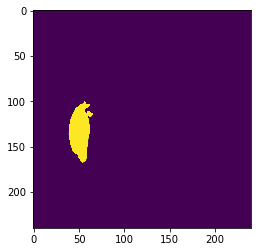

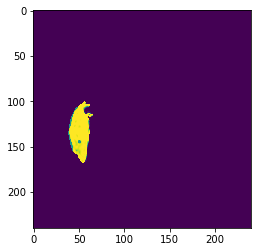

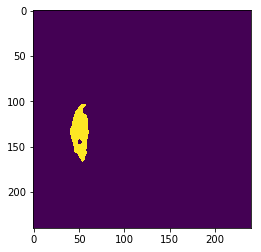

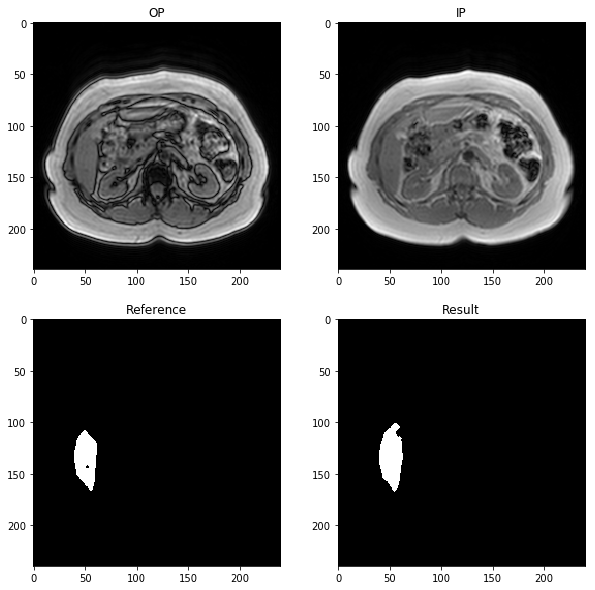

10
10
10
10
10
10


In [48]:
# S01-39

inputOP = np.genfromtxt("dataset02\s03-39-op-432-75-198.txt")
inputIP = np.genfromtxt("dataset02\s03-39-ip-425.txt")
inputref = np.genfromtxt("dataset02\s03-39-ref.txt")

result_s01_39, dice_f39, jacc_f39, accu_f39, sens_f39, spec_f39, tempo_f39 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s02_39_10.bmp', result_s01_39)

listaDICE_S01_39.append(dice_f39)
listaJACC_S01_39.append(jacc_f39)
listaACCU_S01_39.append(accu_f39)
listaSENS_S01_39.append(sens_f39)
listaSPEC_S01_39.append(spec_f39)
listaTEMPO_S01_39.append(tempo_f39)

print(len(listaDICE_S01_39))
print(len(listaJACC_S01_39))
print(len(listaACCU_S01_39))
print(len(listaSENS_S01_39))
print(len(listaSPEC_S01_39))
print(len(listaTEMPO_S01_39))

del(inputOP)
del(inputIP)
del(inputref)

In [85]:
print np.mean(listaDICE_S01_39)
print np.mean(listaJACC_S01_39)
print np.mean(listaACCU_S01_39)
print np.mean(listaSENS_S01_39)
print np.mean(listaSPEC_S01_39)
print np.mean(listaTEMPO_S01_39)

0.928509282344
0.866564930025
0.997553819444
0.990151515152
0.99767450067
11.9840999842


In [80]:
listaDICE_S01_41 = []
listaJACC_S01_41 = []
listaACCU_S01_41 = []
listaSENS_S01_41 = []
listaSPEC_S01_41 = []
listaTEMPO_S01_41 = []

[(53, 161), (53, 152), (60, 132), (49, 133), (52, 119), (62, 101)]
(62, 101)


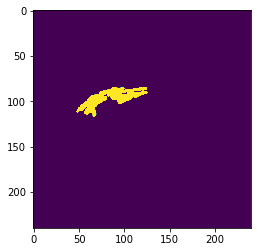

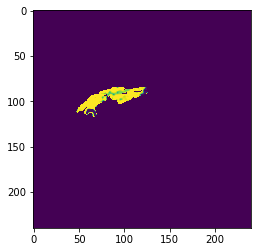

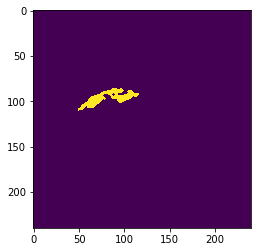

(52, 119)


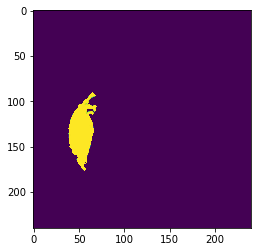

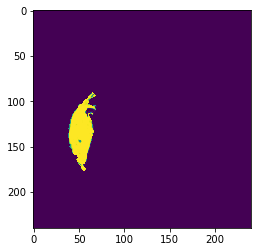

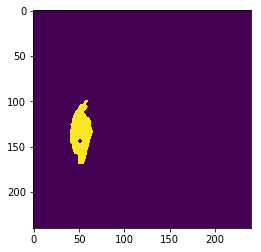

(49, 133)


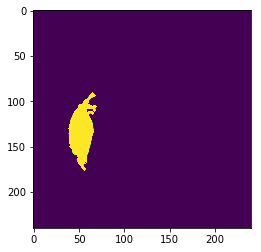

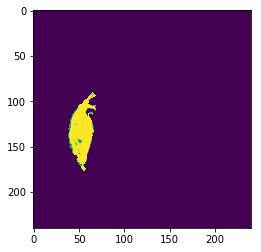

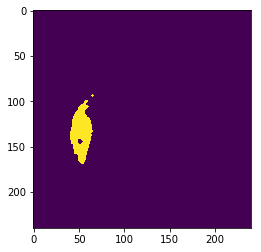

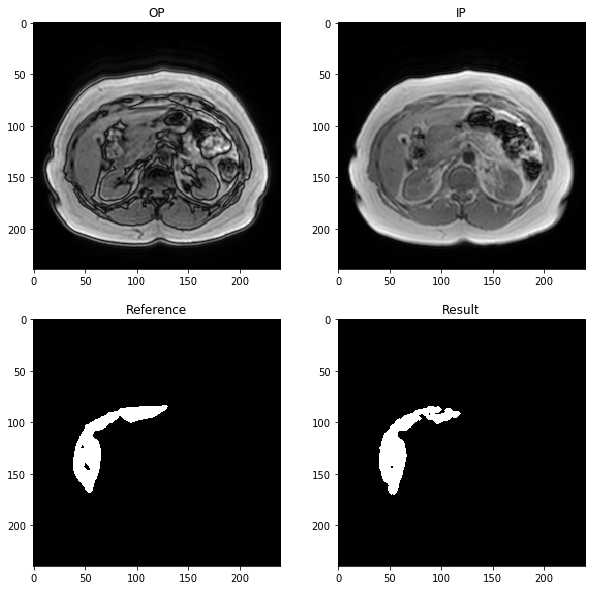

In [102]:
# S01-41

inputIP = np.genfromtxt("dataset02\s03-41-ip-465.txt")
inputOP = np.genfromtxt("dataset02\s03-41-op-449-103-171.txt")
inputref = np.genfromtxt("dataset02\s03-41-ref.txt")

result_s01_41, dice_f41, jacc_f41, accu_f41, sens_f41, spec_f41, tempo_f41_1 = start_segm(inputOP, inputIP, inputref)

[(97, 93), (106, 91), (114, 90)]
(114, 90)


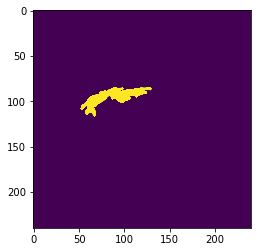

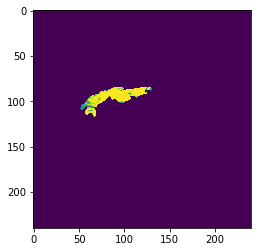

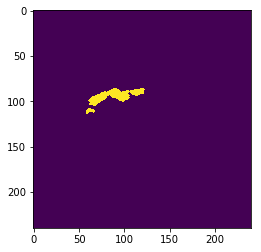

(106, 91)


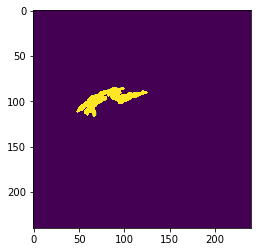

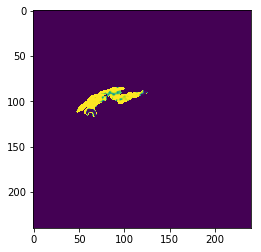

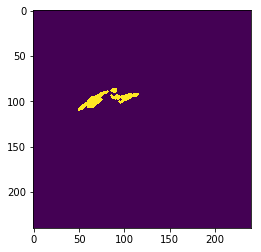

(97, 93)


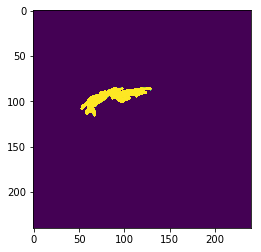

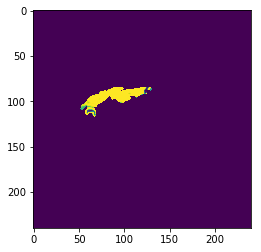

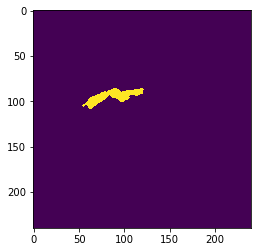

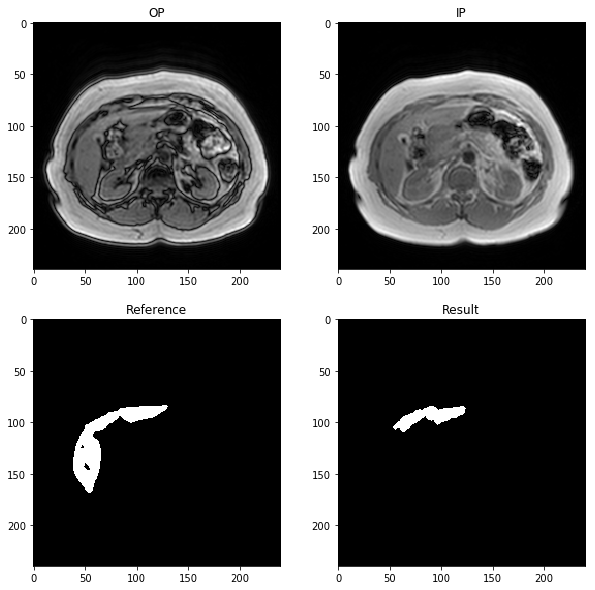

10
10
10
10
10
10


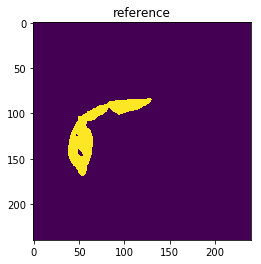

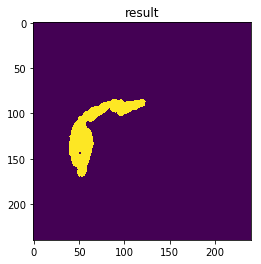

In [103]:
# S01-41_pedaço_MENOR

result_s01_41_1, dice_f41_1, jacc_f41_1, accu_f41_1, sens_f41_1, spec_f41_1, tempo_f41_1 = start_segm(inputOP, inputIP, inputref)

final_s01_41, dice_f41, jacc_f41, accu_f41, sens_f41, spec_f41, tempo_f41 = junta_imgs(inputref, result_s01_41, result_s01_41_1)

misc.imsave('result_s02_41_10.bmp', final_s01_41)

listaDICE_S01_41.append(dice_f41)
listaJACC_S01_41.append(jacc_f41)
listaACCU_S01_41.append(accu_f41)
listaSENS_S01_41.append(sens_f41)
listaSPEC_S01_41.append(spec_f41)
listaTEMPO_S01_41.append(tempo_f41+tempo_f41_1)

print(len(listaDICE_S01_41))
print(len(listaJACC_S01_41))
print(len(listaACCU_S01_41))
print(len(listaSENS_S01_41))
print(len(listaSPEC_S01_41))
print(len(listaTEMPO_S01_41))

plt.imshow(inputref)
plt.title('reference')
plt.show()
plt.imshow(final_s01_41)
plt.title('result')
plt.show()

del(inputOP)
del(inputIP)
del(inputref)

In [104]:
print np.mean(listaDICE_S01_41)
print np.mean(listaJACC_S01_41)
print np.mean(listaACCU_S01_41)
print np.mean(listaSENS_S01_41)
print np.mean(listaSPEC_S01_41)
print np.mean(listaTEMPO_S01_41)

0.925100688614
0.860672541416
0.994697916667
0.935714285714
0.996837219344
11.0980000257


In [121]:
del(inputOP)
del(inputIP)
del(inputref)

In [108]:
listaDICE_S01_43 = []
listaJACC_S01_43 = []
listaACCU_S01_43 = []
listaSENS_S01_43 = []
listaSPEC_S01_43 = []
listaTEMPO_S01_43 = []

[(53, 160), (62, 134), (56, 121), (72, 102), (101, 98), (119, 93)]
(101, 98)


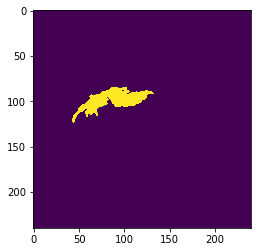

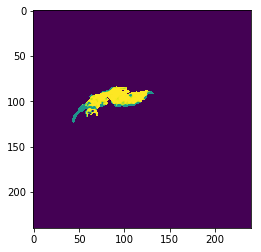

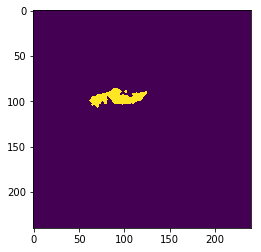

(56, 121)


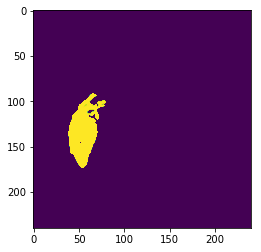

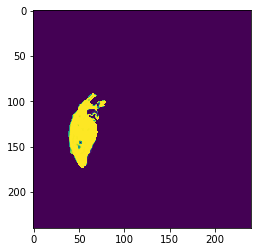

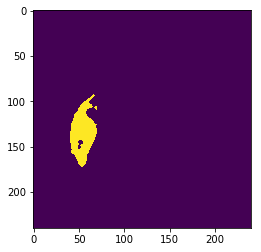

(62, 134)


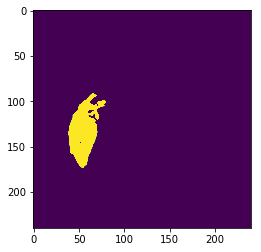

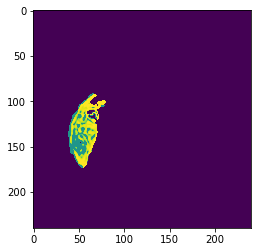

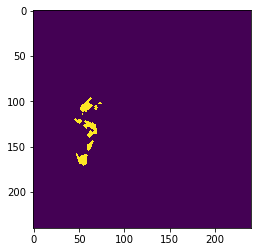

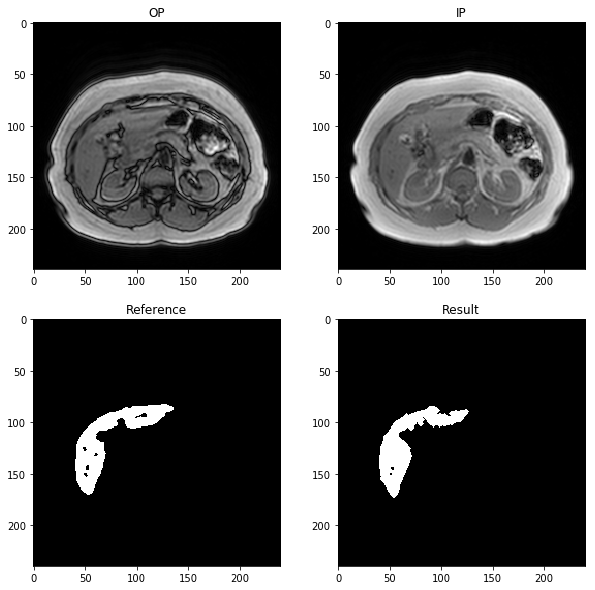

10
10
10
10
10
10


In [118]:
# S01-43

inputOP = np.genfromtxt("dataset02\s03-43-op-452-110-169.txt")
inputIP = np.genfromtxt("dataset02\s03-43-ip-459.txt")
inputref = np.genfromtxt("dataset02\s03-43-ref.txt")

result_s01_43, dice_f43, jacc_f43, accu_f43, sens_f43, spec_f43, tempo_f43 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s02_43_10.bmp', result_s01_43)

listaDICE_S01_43.append(dice_f43)
listaJACC_S01_43.append(jacc_f43)
listaACCU_S01_43.append(accu_f43)
listaSENS_S01_43.append(sens_f43)
listaSPEC_S01_43.append(spec_f43)
listaTEMPO_S01_43.append(tempo_f43)

print(len(listaDICE_S01_43))
print(len(listaJACC_S01_43))
print(len(listaACCU_S01_43))
print(len(listaSENS_S01_43))
print(len(listaSPEC_S01_43))
print(len(listaTEMPO_S01_43))

del(inputOP)
del(inputIP)
del(inputref)

In [119]:
print np.mean(listaDICE_S01_43)
print np.mean(listaJACC_S01_43)
print np.mean(listaACCU_S01_43)
print np.mean(listaSENS_S01_43)
print np.mean(listaSPEC_S01_43)
print np.mean(listaTEMPO_S01_43)

0.887617379565
0.798229407174
0.9904375
0.881877022654
0.995305470904
14.8003999949


In [120]:
listaDICE_S01_45 = []
listaJACC_S01_45 = []
listaACCU_S01_45 = []
listaSENS_S01_45 = []
listaSPEC_S01_45 = []
listaTEMPO_S01_45 = []

[(57, 164), (76, 133), (48, 130), (62, 113), (76, 97), (102, 88), (119, 84), (107, 110)]
(76, 97)


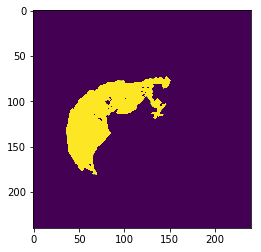

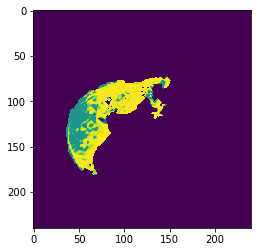

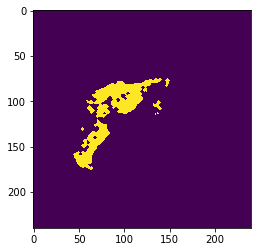

(107, 110)


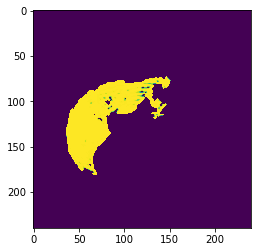

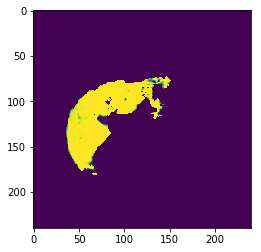

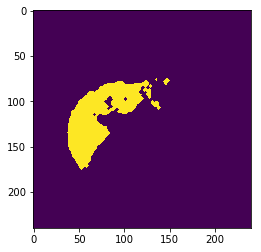

(57, 164)


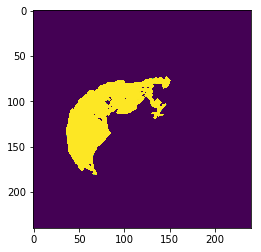

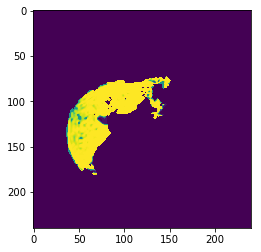

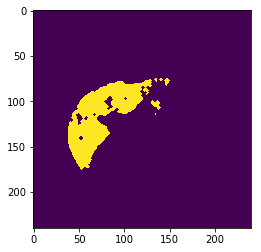

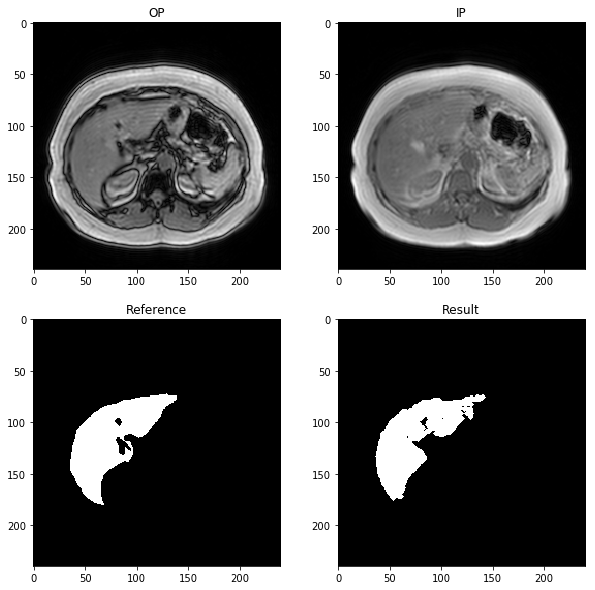

10
10
10
10
10
10


In [131]:
# S01-45

inputOP = np.genfromtxt("dataset02\s03-45-op-462-111-171.txt")
inputIP = np.genfromtxt("dataset02\s03-45-ip-462.txt")
inputref = np.genfromtxt("dataset02\s03-45-ref.txt")

result_s01_45, dice_f45, jacc_f45, accu_f45, sens_f45, spec_f45, tempo_f45 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s02_45_10.bmp', result_s01_45)

listaDICE_S01_45.append(dice_f45)
listaJACC_S01_45.append(jacc_f45)
listaACCU_S01_45.append(accu_f45)
listaSENS_S01_45.append(sens_f45)
listaSPEC_S01_45.append(spec_f45)
listaTEMPO_S01_45.append(tempo_f45)

print(len(listaDICE_S01_45))
print(len(listaJACC_S01_45))
print(len(listaACCU_S01_45))
print(len(listaSENS_S01_45))
print(len(listaSPEC_S01_45))
print(len(listaTEMPO_S01_45))

del(inputOP)
del(inputIP)
del(inputref)

In [132]:
print np.mean(listaDICE_S01_45)
print np.mean(listaJACC_S01_45)
print np.mean(listaACCU_S01_45)
print np.mean(listaSENS_S01_45)
print np.mean(listaSPEC_S01_45)
print np.mean(listaTEMPO_S01_45)

0.925112661289
0.860671845923
0.988131944444
0.893693121693
0.996571158392
29.6941999912


In [135]:
DICET = [listaDICE_S01_35, listaDICE_S01_37, listaDICE_S01_39, listaDICE_S01_41, listaDICE_S01_43, listaDICE_S01_45]
JACCT = [listaJACC_S01_35, listaJACC_S01_37, listaJACC_S01_39, listaJACC_S01_41, listaJACC_S01_43, listaJACC_S01_45]
ACCUT = [listaACCU_S01_35, listaACCU_S01_37, listaACCU_S01_39, listaACCU_S01_41, listaACCU_S01_43, listaACCU_S01_45]
SENST = [listaSENS_S01_35, listaSENS_S01_37, listaSENS_S01_39, listaSENS_S01_41, listaSENS_S01_43, listaSENS_S01_45]
SPECT = [listaSPEC_S01_35, listaSPEC_S01_37, listaSPEC_S01_39, listaSPEC_S01_41, listaSPEC_S01_43, listaSPEC_S01_45]
TEMPOT = [listaTEMPO_S01_35, listaTEMPO_S01_37, listaTEMPO_S01_39, listaTEMPO_S01_41, listaTEMPO_S01_43, listaTEMPO_S01_45]

print('MEDIA TOTAL')

print(np.mean(DICET))
print(np.mean(JACCT))
print(np.mean(ACCUT))
print(np.mean(SENST))
print(np.mean(SPECT))
print(np.mean(TEMPOT))

print('DESVIO TOTAL')

print(np.std(DICET))
print(np.std(JACCT))
print(np.std(ACCUT))
print(np.std(SENST))
print(np.std(SPECT))
print(np.std(TEMPOT))

MEDIA TOTAL
0.908370717312
0.832806188353
0.994370949074
0.935482379758
0.997082746765
14.6997833292
DESVIO TOTAL
0.0212391900992
0.035080023335
0.0038416734855
0.048418525327
0.0010786990503
7.00933257058
